# Ecosystem Transition Exploration (361 / Dafi)

This notebook performs **exploratory analysis of ecosystem expansion** using the
canonical, MULTI-aware lifecycle dataset:

- `ecosystem_add_events.parquet`

Each row represents **one true ecosystem addition event**, defined via
set-difference on cumulative ecosystem ownership.

This notebook is **read-only with respect to lifecycle logic**.
All derivation is assumed correct and frozen.


In [14]:
import pandas as pd

from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

DATA_DIR = Path("../data/interim")

events = pd.read_parquet(DATA_DIR / "ecosystem_add_events.parquet")

print("Rows (addition events):", len(events))
print("Unique customers:", events["anon"].nunique())
print("Unique ecosystems added:", events["added_ecosystem"].nunique())

display(events.head())


Rows (addition events): 77894
Unique customers: 52157
Unique ecosystems added: 10


,anon,purchase_k,date,order_ecos,added_ecosystem,has_expansion,prev_ecos_str,curr_ecos_str
0,ANON_0000009,2,2025-11-19,[bottle],bottle,True,pitcher,"bottle, pitcher"
1,ANON_0000011,2,2024-02-19,"[other, pitcher]",other,True,pitcher,"other, pitcher"
2,ANON_0000012,2,2024-09-26,"[pitcher, bottle]",bottle,True,pitcher,"bottle, pitcher"
3,ANON_0000019,2,2023-06-20,[bottle],None,False,bottle,bottle
4,ANON_0000027,2,2023-04-06,[pitcher],pitcher,True,bottle,"bottle, pitcher"


In [29]:
events["prev_ecos_set"] = events["prev_ecos_str"].apply(
    lambda s: set(s.split(", ")) if isinstance(s, str) else set()
)




import pandas as pd
import numpy as np

def ecosystem_transition_matrix(events, k):
    """
    Build a row-normalized ecosystem transition matrix for step k -> k+1
    """
    step = events[events["purchase_k"] == k + 1].copy()

    # customers who actually reached this step
    n_customers = step["anon"].nunique()

    # collect all ecosystems
    ecos = sorted(
        set().union(*step["prev_ecos_set"])
        | set().union(*step["order_ecos"])
    )

    counts = pd.DataFrame(0, index=ecos, columns=ecos, dtype=int)
    denom = pd.Series(0, index=ecos, dtype=int)

    for _, r in step.iterrows():
        prev = r["prev_ecos_set"]
        bought = r["order_ecos"]

        for y in prev:
            denom[y] += 1
            for x in bought:
                counts.loc[y, x] += 1

    probs = counts.div(denom, axis=0).fillna(0)

    return probs, n_customers


In [30]:
import matplotlib.pyplot as plt

def plot_transition(M, k, n):
    plt.figure(figsize=(12, 9))
    im = plt.imshow(M.values, aspect="auto")

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Transition probability")

    plt.xticks(range(len(M.columns)), M.columns, rotation=45, ha="right")
    plt.yticks(range(len(M.index)), M.index)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M.iloc[i, j]
            if val > 0.02:
                plt.text(j, i, f"{val:.0%}", ha="center", va="center", color="white")

    plt.title(f"Ecosystem transitions {k} → {k+1} (n={n:,})")
    plt.xlabel("Ecosystem bought at k+1")
    plt.ylabel("Ecosystem owned before k+1")

    plt.tight_layout()
    plt.show()


In [31]:
matrices = {}

for k in [1, 2, 3, 4]:
    M, n = ecosystem_transition_matrix(events, k)
    matrices[k] = (M, n)
    print(f"{k} → {k+1}: n_customers = {n:,}")




1 → 2: n_customers = 52,157
2 → 3: n_customers = 14,439
3 → 4: n_customers = 5,226
4 → 5: n_customers = 2,244


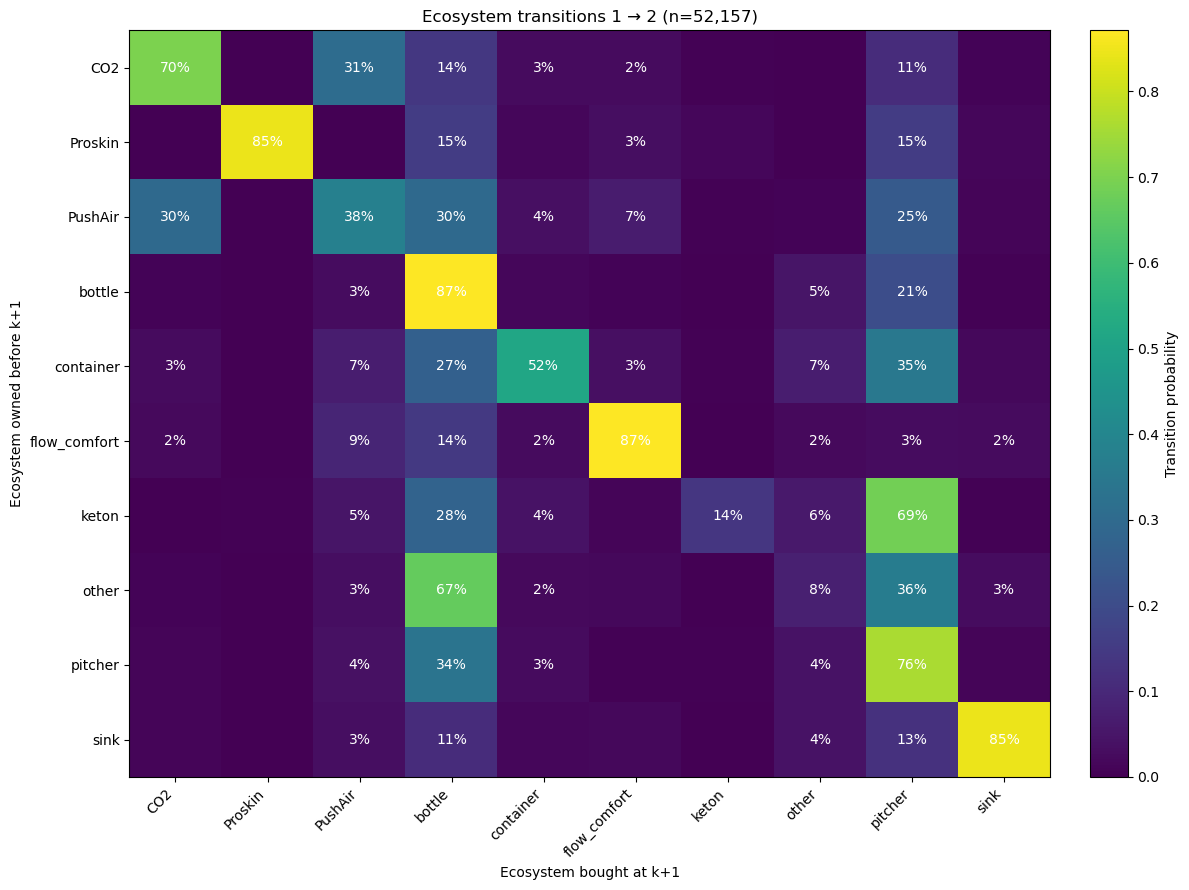

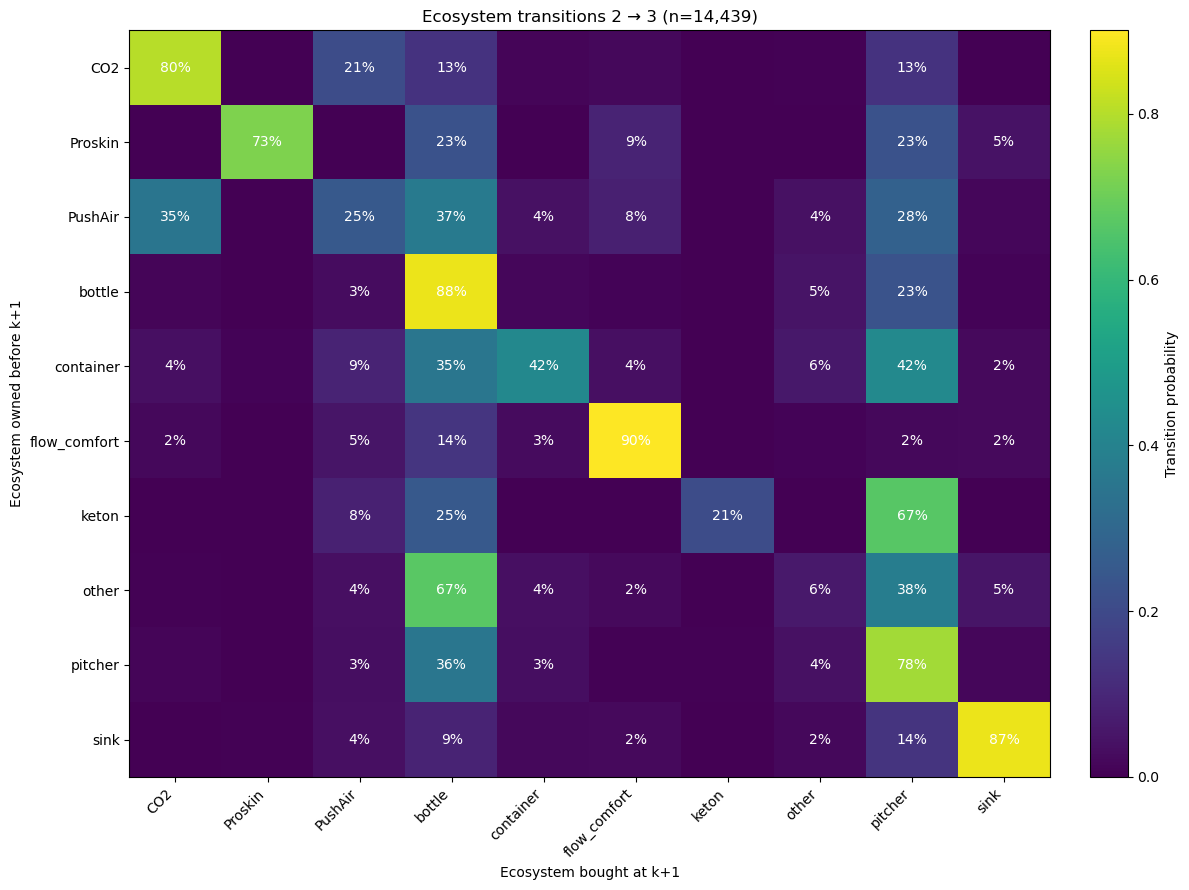

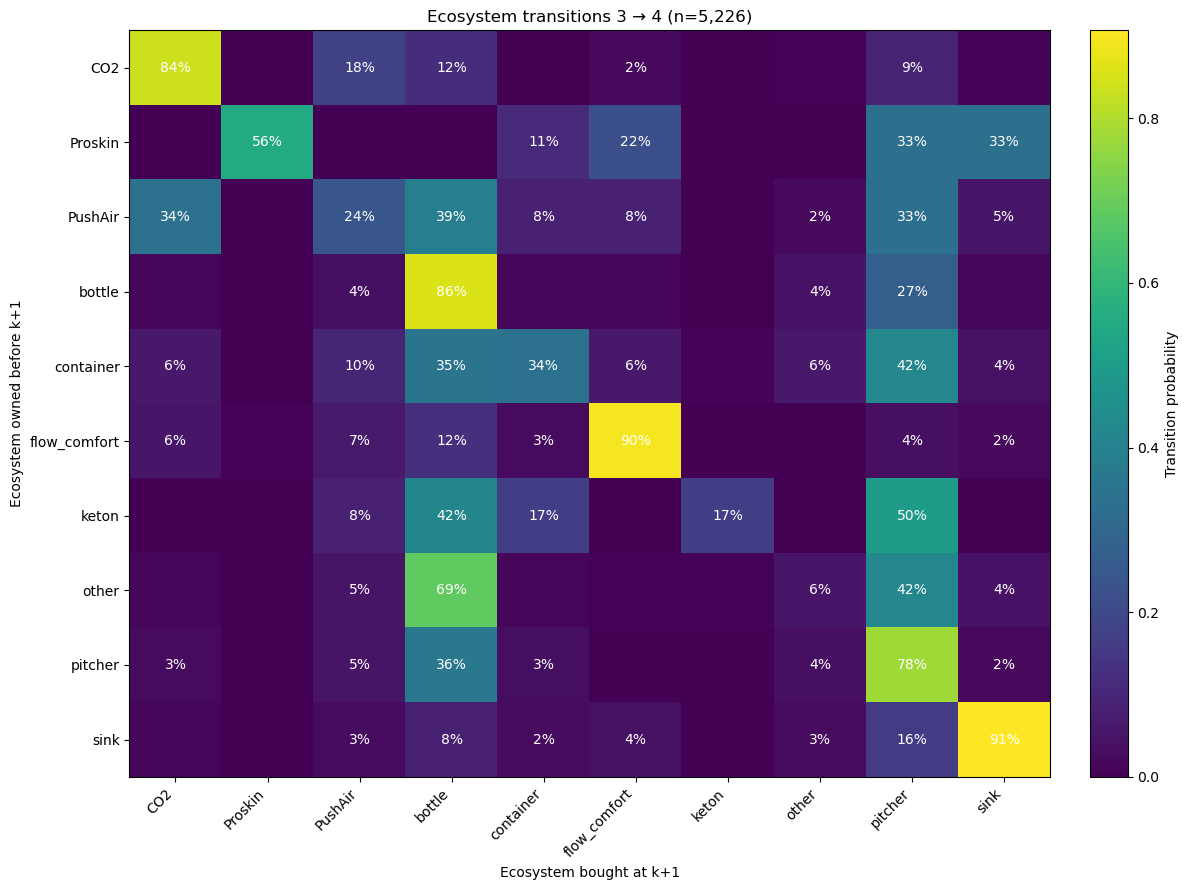

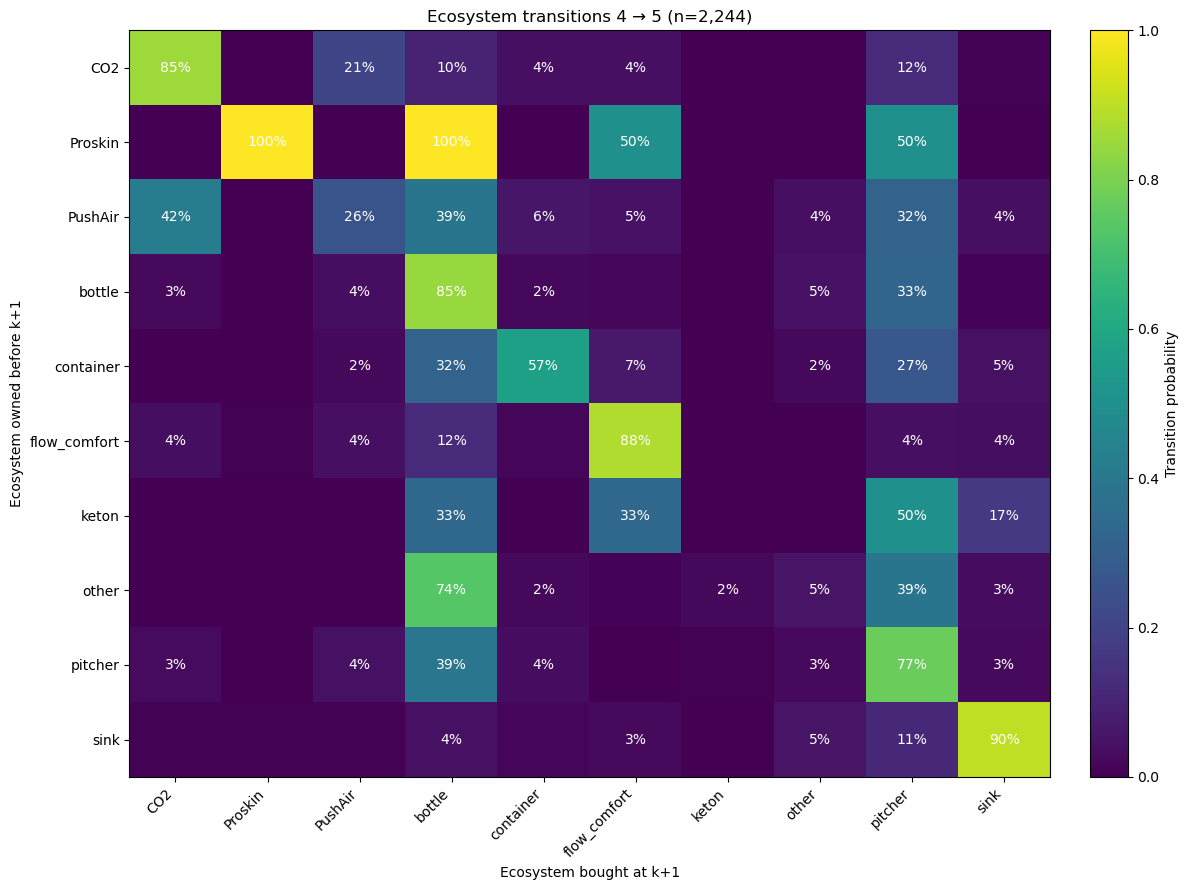

In [32]:
for k, (M, n) in matrices.items():
    plot_transition(M, k, n)


In [36]:
df=events
# keep only expansion events
exp = df[df["has_expansion"] & df["added_ecosystem"].notna()].copy()

# first time each ecosystem appears per customer
first_add = (
    exp
    .sort_values(["anon", "purchase_k"])
    .drop_duplicates(["anon", "added_ecosystem"])
)

# build ordered chains
chains = (
    first_add
    .groupby("anon")["added_ecosystem"]
    .apply(list)
    .reset_index(name="chain")
)

chains["chain_len"] = chains["chain"].str.len()
chains = chains[chains["chain_len"] >= 2]

chains["chain_str"] = chains["chain"].apply(lambda x: " → ".join(x))

# top paths
path_counts = (
    chains["chain_str"]
    .value_counts(normalize=True)
    .head(10)
    .mul(100)
    .reset_index()
    .rename(columns={"index": "path", "chain_str": "share_pct"})
)

path_counts


,share_pct,proportion
0,pitcher → bottle,13.135889
1,bottle → pitcher,10.069686
2,other → pitcher,9.930314
3,PushAir → bottle,5.574913
4,PushAir → pitcher,5.505226
5,other → bottle,4.912892
6,container → pitcher,3.275261
7,container → bottle,2.404181
8,CO2 → PushAir,2.334495
9,PushAir → CO2,1.951220


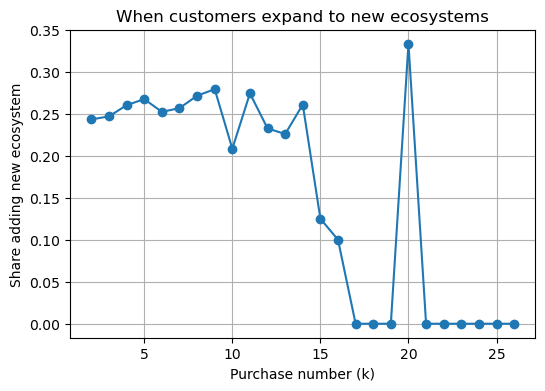

In [38]:
timing = (
    df.groupby("purchase_k")
      .agg(
          customers=("anon", "nunique"),
          expanders=("has_expansion", "sum")
      )
      .assign(expansion_rate=lambda x: x["expanders"] / x["customers"])
      .reset_index()
)

timing


import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(timing["purchase_k"], timing["expansion_rate"], marker="o")
plt.xlabel("Purchase number (k)")
plt.ylabel("Share adding new ecosystem")
plt.title("When customers expand to new ecosystems")
plt.grid(True)
plt.show()


In [39]:
# customers who owned ecosystem E by purchase k
owned_by_k = (
    df.groupby(["anon", "purchase_k"])["curr_ecos_str"]
      .first()
      .reset_index()
)

def owned(ecos, s):
    return ecos in s.split(", ")

# evaluate at k=2 → next 2 purchases
k0 = 2

base = owned_by_k[owned_by_k["purchase_k"] == k0][["anon", "curr_ecos_str"]]

future_exp = (
    df[df["purchase_k"].between(k0+1, k0+2)]
    .groupby("anon")["has_expansion"]
    .sum()
    .rename("future_expansions")
    .reset_index()
)

gateway = base.merge(future_exp, on="anon", how="left").fillna(0)

records = []
ecosystems = sorted({e for s in base["curr_ecos_str"] for e in s.split(", ")})

for e in ecosystems:
    m = gateway[gateway["curr_ecos_str"].apply(lambda x: owned(e, x))]
    records.append({
        "ecosystem": e,
        "avg_future_expansion": m["future_expansions"].mean(),
        "n_customers": len(m)
    })

gateway_df = pd.DataFrame(records).sort_values("avg_future_expansion", ascending=False)
gateway_df


,ecosystem,avg_future_expansion,n_customers
0,CO2,0.242946,1453
2,PushAir,0.175653,2949
4,container,0.167763,1824
5,flow_comfort,0.139679,1933
6,keton,0.139344,244
8,pitcher,0.120203,22903
9,sink,0.107713,2256
1,Proskin,0.106383,94
3,bottle,0.098183,36218
7,other,0.096507,4352


In [40]:
# total ecosystems owned by purchase 5
depth = (
    df[df["purchase_k"] == 5]
    .assign(depth=lambda x: x["curr_ecos_str"].str.split(", ").str.len())
    [["anon", "depth"]]
)

path_depth = (
    chains.merge(depth, on="anon", how="left")
)

path_depth.groupby("chain_str")["depth"].mean().sort_values(ascending=False)


chain_str
pitcher → bottle → CO2 → container → PushAir    5.0
PushAir → bottle → CO2 → container → pitcher    5.0
sink → flow_comfort → CO2 → PushAir → bottle    5.0
CO2 → pitcher → PushAir → bottle → container    4.0
container → bottle → pitcher → sink             4.0
                                               ... 
sink → container                                NaN
sink → container → bottle → pitcher             NaN
sink → container → pitcher                      NaN
sink → flow_comfort                             NaN
sink → other → bottle                           NaN
Name: depth, Length: 303, dtype: float64

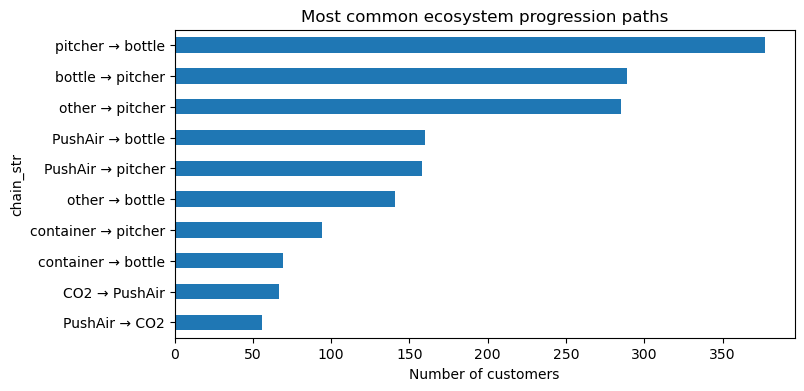

In [42]:
# build first-appearance chains
exp = df[df["has_expansion"] & df["added_ecosystem"].notna()].copy()

first_add = (
    exp.sort_values(["anon", "purchase_k"])
       .drop_duplicates(["anon", "added_ecosystem"])
)

chains = (
    first_add.groupby("anon")["added_ecosystem"]
             .apply(list)
             .reset_index(name="chain")
)

chains["chain_len"] = chains["chain"].str.len()
chains = chains[chains["chain_len"] >= 2]

chains["chain_str"] = chains["chain"].apply(lambda x: " → ".join(x))

path_counts = chains["chain_str"].value_counts().head(10)

plt.figure(figsize=(8,4))
path_counts.sort_values().plot(kind="barh")
plt.xlabel("Number of customers")
plt.title("Most common ecosystem progression paths")
plt.show()


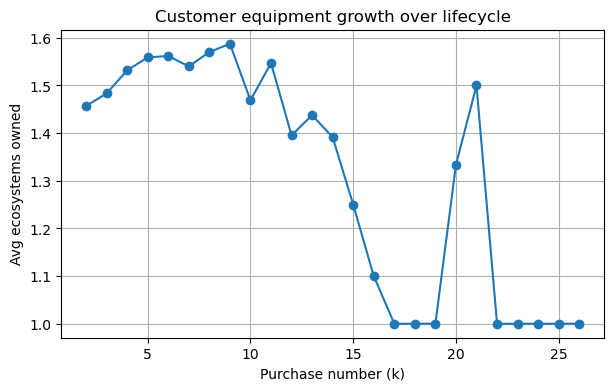

In [43]:
depth = (
    df.groupby("purchase_k")["curr_ecos_str"]
      .apply(lambda x: x.str.split(", ").str.len().mean())
      .reset_index(name="avg_ecos_owned")
)

plt.figure(figsize=(7,4))
plt.plot(depth["purchase_k"], depth["avg_ecos_owned"], marker="o")
plt.xlabel("Purchase number (k)")
plt.ylabel("Avg ecosystems owned")
plt.title("Customer equipment growth over lifecycle")
plt.grid(True)
plt.show()


<Figure size 700x400 with 0 Axes>

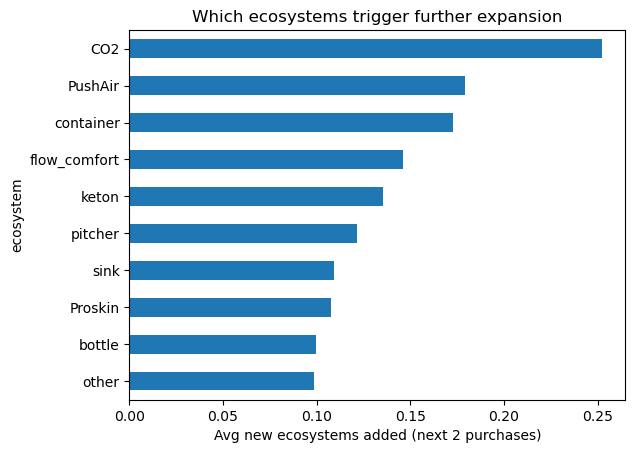

In [44]:
k0 = 2

owned_k = (
    df[df["purchase_k"] == k0][["anon", "curr_ecos_str"]]
)

future_exp = (
    df[df["purchase_k"].between(k0+1, k0+2)]
      .groupby("anon")["has_expansion"]
      .sum()
      .rename("future_exp")
      .reset_index()
)

base = owned_k.merge(future_exp, on="anon", how="left").fillna(0)

def owns(ecos, s):
    return ecos in s.split(", ")

ecosystems = sorted({e for s in base["curr_ecos_str"] for e in s.split(", ")})

rows = []
for e in ecosystems:
    m = base[base["curr_ecos_str"].apply(lambda x: owns(e, x))]
    rows.append((e, m["future_exp"].mean()))

gateway = pd.DataFrame(rows, columns=["ecosystem", "avg_future_exp"])

plt.figure(figsize=(7,4))
gateway.sort_values("avg_future_exp").plot(
    x="ecosystem", y="avg_future_exp", kind="barh", legend=False
)
plt.xlabel("Avg new ecosystems added (next 2 purchases)")
plt.title("Which ecosystems trigger further expansion")
plt.show()
